## Configuracion de Entorno

In [ ]:
import os

# Si estás en Jupyter Notebook, anclás a una ruta conocida o fija:
project_root = r"C:\Users\juanm\GitHub\UA_MDM_Labo2_G9"  # Personalizar esto

# Alternativa: usar una carpeta conocida dentro del proyecto
# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Menos frágil

# Rutas de trabajo
workDir = os.path.join(project_root, "work")
optunaArtifactDir = os.path.join(workDir, "optuna_artifacts")
optunaTempDir = os.path.join(workDir, "optuna_temp_artifacts")

# Crear carpetas si no existen
os.makedirs(optunaArtifactDir, exist_ok=True)
os.makedirs(optunaTempDir, exist_ok=True)

# Cambiar al directorio de trabajo solo si es necesario
if os.getcwd() != workDir:
    os.chdir(workDir)

print("Directorio actual:", os.getcwd())


Directorio actual: C:\Users\juanm\GitHub\UA_MDM_Labo2_G9\work


In [2]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Modelado: Gradient Boosting
import lightgbm as lgb

# Sklearn: splits, métricas y utilidades
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Visualización
import matplotlib.pyplot as plt  # Usar junto con seaborn o plotly si es necesario
import plotly.express as px      # Corrección: no usar `from plotly import express as px`

# Optuna para optimización de hiperparámetros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

# Utilidades propias
from utiles import plot_confusion_matrix

# Guardado de objetos
from joblib import dump, load

# Sistema
import os

c:\Users\juanm\anaconda3\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Datos de razas 
PATH_TO_BREED_LABELS = os.path.join(BASE_DIR, "modelo/data/petfinder-adoption-prediction/BreedLabels.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

## Descripcion Feature Engineering

Con base en el script actualizado de ingeniería de características que me compartiste, te actualizo la descripción de las transformaciones del dataset para que estén alineadas con las variables efectivamente generadas:

---

### 🔹 1. **Transformaciones directas útiles**

Variables originales reformuladas para aportar más valor predictivo al modelo.

| Variable     | Qué hace                                                                  | Por qué ayuda                                                           |
| ------------ | ------------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| `HasName`    | Indica si el animal tiene nombre                                          | Un nombre puede hacer al animal más cercano y memorable para adoptantes |
| `PureBreed`  | Indica si el animal es de raza pura (`Breed2 == 0` y no contiene "Mixed") | Ayuda a capturar la preferencia por razas específicas                   |
| `DescLength` | Longitud de la descripción textual                                        | Más texto puede reflejar mayor esfuerzo y generar más interés           |
| `Fee_log`    | (No generado en el script, pero se puede incluir) Logaritmo del precio    | Suaviza la distribución y reduce el impacto de valores extremos         |
| `IsFree`     | (Sugerido) `Fee == 0`                                                     | La gratuidad puede aumentar la intención de adopción                    |

**Objetivo**: transformar variables originales en formas más robustas o informativas para el modelo.

---

### 🔹 2. **Reagrupaciones o codificaciones útiles**

Nuevas variables creadas mediante categorización o codificación combinada.

| Variable           | Qué hace                                                                 | Por qué ayuda                                             |
| ------------------ | ------------------------------------------------------------------------ | --------------------------------------------------------- |
| `Type_Breed_Combo` | Combina el tipo de animal con el ID de la raza principal                 | Algunas combinaciones pueden ser más atractivas que otras |
| `Fee_Breed_Ratio`  | Relación entre la tarifa individual y el promedio de tarifa para su raza | Detecta casos con precio inusualmente alto o bajo         |

**Objetivo**: facilitar el aprendizaje del modelo mediante agrupaciones con patrones compartidos.

---

### 🔹 3. **Interacciones entre variables**

Variables creadas a partir de combinaciones que expresan relaciones no lineales.

| Variable               | Qué hace                                                  | Por qué ayuda                                       |
| ---------------------- | --------------------------------------------------------- | --------------------------------------------------- |
| `Fee_per_Pet`          | Tarifa dividida por cantidad de mascotas                  | Normaliza la tarifa para adopciones múltiples       |
| `Photo_per_Pet`        | Cantidad de fotos por mascota                             | Mide el esfuerzo visual por cada animal             |
| `Age_Fee_Ratio`        | Edad dividida por tarifa (más 1)                          | Detecta casos inusuales de edad vs. valor monetario |
| `DescLength_per_Pet`   | Longitud de descripción dividida por cantidad de mascotas | Indica esfuerzo textual por cada animal             |
| `DescLength_per_Photo` | Longitud de descripción dividida por cantidad de fotos    | Relaciona el detalle textual con el esfuerzo visual |

**Objetivo**: capturar relaciones entre variables que puedan influir en decisiones de adopción.

## Feature Engineering

In [4]:
import numpy as np
import pandas as pd

# Cargar el dataset
dataset = pd.read_csv(PATH_TO_TRAIN)

# 1. Tiene nombre
dataset['HasName'] = dataset['Name'].notnull().astype(int)

# 2. Es de raza pura
# Cargar etiquetas de razas
breed_labels = pd.read_csv(PATH_TO_BREED_LABELS)

# Diccionario ID → Nombre de raza
id_to_breed = dict(zip(breed_labels['BreedID'], breed_labels['BreedName']))

# Crear una nueva columna con el nombre de Breed1
dataset['Breed1_name'] = dataset['Breed1'].map(id_to_breed)

dataset['PureBreed'] = (
    (dataset['Breed2'] == 0) &
    (~dataset['Breed1_name'].str.contains('Mixed', case=False, na=False))
).astype(int)

# 3. Longitud de la descripción
dataset['DescLength'] = dataset['Description'].fillna('').apply(len)

# 4. Combinación tipo-raza principal
dataset['Type_Breed_Combo'] = dataset['Type'].astype(str) + '_' + dataset['Breed1'].astype(str)

dataset['Type_Breed_Combo'] = dataset['Type_Breed_Combo'].astype('category')

# 5. Tarifa por mascota
dataset['Fee_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['Fee'] / dataset['Quantity'])

# 6. Fotos por mascota
dataset['Photo_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['PhotoAmt'] / dataset['Quantity'])

# 7. Relación edad/tarifa
dataset['Age_Fee_Ratio'] = dataset['Age'] / (dataset['Fee'] + 1)

# 8. Longitud descripción por mascota
dataset['DescLength_per_Pet'] = np.where(dataset['Quantity'] == 0, 0, dataset['DescLength'] / dataset['Quantity'])

# 9. Longitud descripción por cantidad de fotos 
dataset['DescLength_per_Photo'] = np.where(dataset['PhotoAmt'] == 0,0,dataset['DescLength'] / dataset['PhotoAmt'])

# 10. Tarifa promedio por raza
breed_fee_mean = dataset.groupby('Breed1')['Fee'].mean()

dataset['Fee_Breed_Ratio'] = dataset['Fee'] / (dataset['Breed1'].map(breed_fee_mean) + 1)

In [5]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

#Defino features a usar
features = numeric_feats.copy()

label = 'AdoptionSpeed'

# Eliminamos 'AdoptionSpeed' si está
if 'AdoptionSpeed' in features:
    features.remove('AdoptionSpeed')

#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

features

['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 'HasName',
 'PureBreed',
 'DescLength',
 'Type_Breed_Combo',
 'Fee_per_Pet',
 'Photo_per_Pet',
 'Age_Fee_Ratio',
 'DescLength_per_Pet',
 'DescLength_per_Photo',
 'Fee_Breed_Ratio']

## Modelo con hiperparametros por default

In [6]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model1 = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 29
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359


In [7]:
lgb_model1.predict(X_test).argmax(axis=1)

array([2, 2, 2, ..., 1, 4, 4], shape=(2999,))

In [8]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model1.predict(X_test).argmax(axis=1)

#Calculo el Kappa
print(cohen_kappa_score(y_test,y_pred, weights = 'quadratic'))

#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))

0.34524806594014434


## Modelo con optimizacion de hiperparametros train/test

In [9]:
#Funcion que vamos a optimizar. Optuna requiere que usemos el objeto trial para generar los parametros a optimizar
def lgb_objective(trial):
    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Genero objeto dataset de entrenamiento
    lgb_train_dataset = lgb.Dataset(data=X_train,
                                    label=y_train)

    #ajuste de modelo
    lgb_model2 = lgb.train(lgb_params,
                        lgb_train_dataset)
    
    #Devuelvo el score en test
    return(cohen_kappa_score(y_test,lgb_model2.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

In [ ]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///../work/db_100_LGBM_FE_JM_100.sqlite3",  # Specify the storage URL here.
                            study_name="100_LGBM_FE_JM_100", #nombre del experimento
                            load_if_exists=True) #continuar si ya existe

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2025-05-03 23:40:01,597] A new study created in RDB with name: 100_LGBM_FE_JM_100
[I 2025-05-03 23:40:02,477] Trial 0 finished with value: 0.3281002532364756 and parameters: {'lambda_l1': 5.055556954061397e-07, 'lambda_l2': 9.28252195633546e-06, 'num_leaves': 18, 'feature_fraction': 0.43409281860931204, 'bagging_fraction': 0.720493433729184, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 0 with value: 0.3281002532364756.
[I 2025-05-03 23:40:03,877] Trial 1 finished with value: 0.32484400112035505 and parameters: {'lambda_l1': 6.162993241377382e-05, 'lambda_l2': 5.70570376638077e-06, 'num_leaves': 48, 'feature_fraction': 0.6737003312064161, 'bagging_fraction': 0.9006795589469618, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 0 with value: 0.3281002532364756.
[I 2025-05-03 23:40:07,237] Trial 2 finished with value: 0.3247818995334486 and parameters: {'lambda_l1': 2.3821141692972674, 'lambda_l2': 3.2458881485780514e-05, 'num_leaves': 164, 'feature_fraction': 0.

In [11]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 6.845292694025618e-08,
 'lambda_l2': 2.8355751831184235,
 'num_leaves': 44,
 'feature_fraction': 0.6906843512620886,
 'bagging_fraction': 0.6830045321083795,
 'bagging_freq': 3,
 'min_child_samples': 82}

In [12]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique())} | study.best_params

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model2 = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
print(cohen_kappa_score(y_test,lgb_model2.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

display(plot_confusion_matrix(y_test,lgb_model2.predict(X_test).argmax(axis=1)))



0.3512164792913808


## Modelo con optimizacion de hiperparametros con 5 Fold Cross Validation

In [13]:
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np
import os
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return (metric_name, value, is_higher_better)

def cv_es_lgb_objective(trial):
    
    # Inicio el store de artefactos (archivos) de Optuna
    artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

    # Hiperparámetros a optimizar
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_jobs': -1
    }
    
    scores_ensemble = np.zeros((len(y_test), len(y_train.unique())))
    score_folds = 0
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):

        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                     label=y_train.iloc[if_index],
                                     free_raw_data=False)
        
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                      label=y_train.iloc[oof_index],
                                      free_raw_data=False)
                
        lgb_model3 = lgb.train(
            lgb_params,
            lgb_if_dataset,
            valid_sets=lgb_oof_dataset,
            callbacks=[lgb.early_stopping(10, verbose=False)],
            feval=lgb_custom_metric_kappa
        )
        
        scores_ensemble += lgb_model3.predict(X_test)

        score_folds += cohen_kappa_score(
            y_train.iloc[oof_index],
            lgb_model3.predict(X_train.iloc[oof_index]).argmax(axis=1),
            weights='quadratic'
        ) / n_splits
    
    # Guardar predicciones sobre test
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p, :] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)

    # Uso keyword arguments en upload_artifact. Asociar las predicciones como artefacto.
    upload_artifact(
        study_or_trial=trial,
        file_path=predicted_filename,
        artifact_store=artifact_store
    )

    # Generar nombre de archivo (¡esto es un string, no lo pises!)
    cm_filename = os.path.join(PATH_TO_TEMP_FILES, f'cm_{trial.study.study_name}_{trial.number}.jpg')

    # Crear y guardar matriz de confusión
    cm = confusion_matrix(y_test, scores_ensemble.argmax(axis=1))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.savefig(cm_filename)
    plt.close()

    # Uso keyword arguments en upload_artifact. Asociar la imagen como artefacto
    upload_artifact(
        study_or_trial=trial,
        file_path=cm_filename,
        artifact_store=artifact_store
    )
    
    # Guardar el score en test como métrica auxiliar
    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    # Devuelvo el promedio de los scores del CV (objetivo a maximizar)
    return score_folds

In [ ]:
import optuna

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db_100_LGBM_FE_JM_100.sqlite3",
                            study_name="100_LGBM_FE_JM_100_CV",
                            load_if_exists = True)

#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

[I 2025-05-03 23:42:28,156] A new study created in RDB with name: 100_LGBM_FE_JM_100_CV
[I 2025-05-03 23:42:34,005] Trial 0 finished with value: 0.3511579100049229 and parameters: {'lambda_l1': 6.268702285036272, 'lambda_l2': 1.8092040477577867e-06, 'num_leaves': 76, 'feature_fraction': 0.7078299525937497, 'bagging_fraction': 0.6561586127976612, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 0 with value: 0.3511579100049229.
[I 2025-05-03 23:42:40,432] Trial 1 finished with value: 0.33757370796304864 and parameters: {'lambda_l1': 0.0005003428466066577, 'lambda_l2': 0.026484346876856423, 'num_leaves': 178, 'feature_fraction': 0.7716322634176257, 'bagging_fraction': 0.7389183160475512, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 0 with value: 0.3511579100049229.
[I 2025-05-03 23:42:45,190] Trial 2 finished with value: 0.3329721751725863 and parameters: {'lambda_l1': 0.2112764045419158, 'lambda_l2': 0.00031572167755850185, 'num_leaves': 47, 'feature_fraction': 0

## LGBM Importance Futures

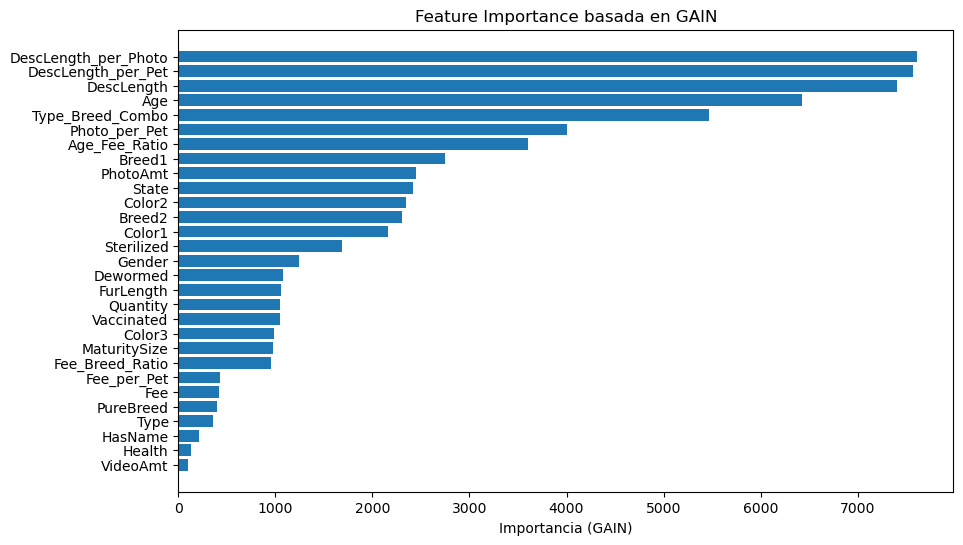

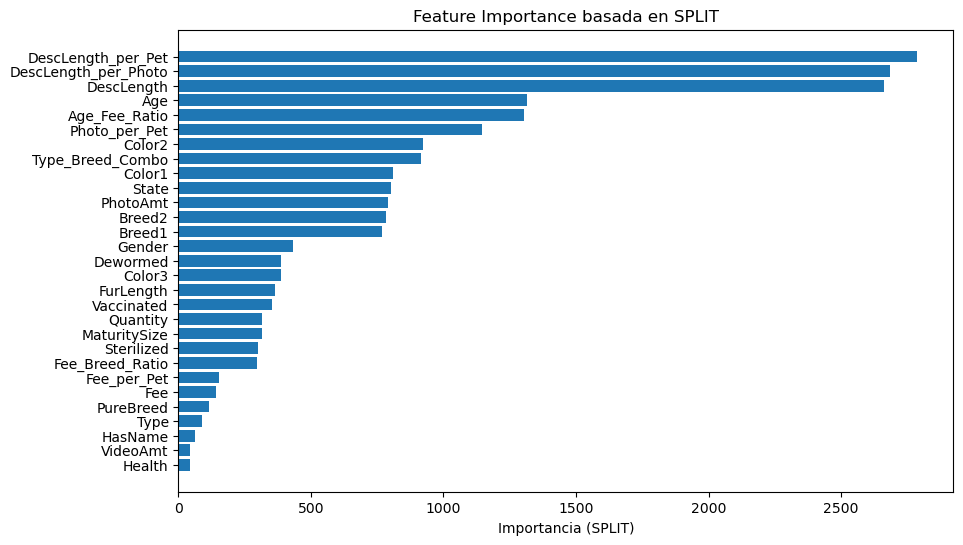

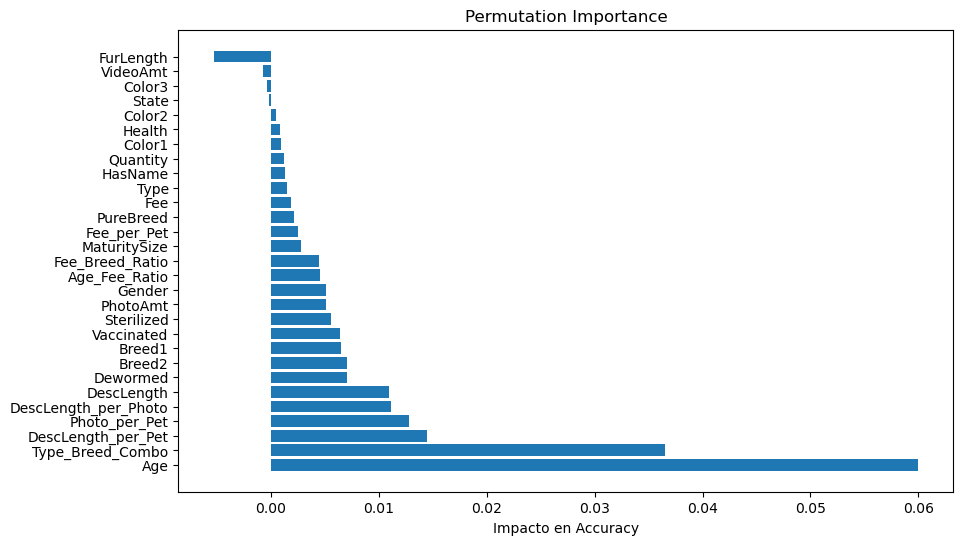

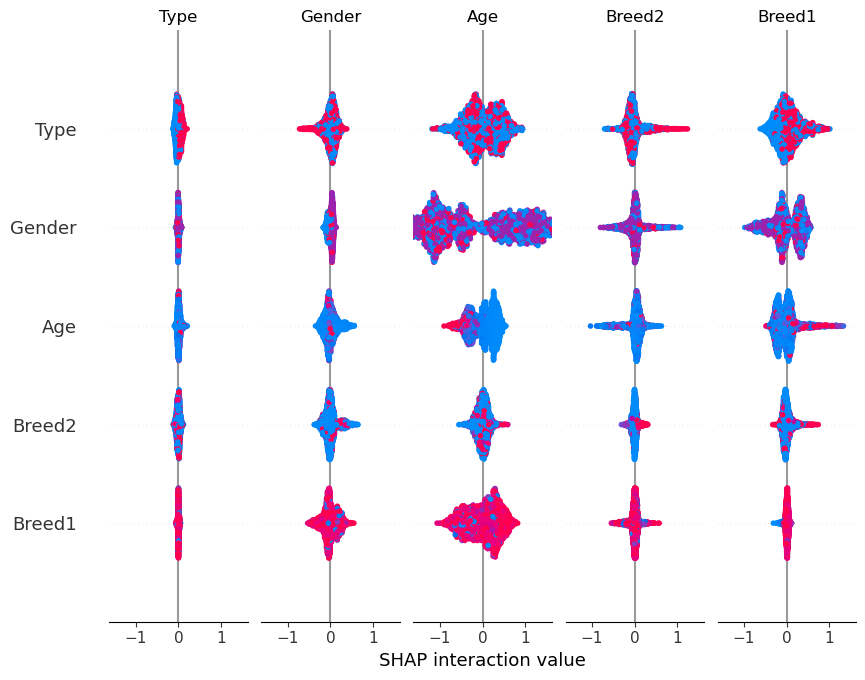

In [15]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

features = np.array(features)
model= lgb_model2

# --------------------
# 1. Feature Importance basada en GAIN
# --------------------
importances_gain = model.feature_importance(importance_type='gain')
sorted_idx_gain = importances_gain.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_gain], importances_gain[sorted_idx_gain])
plt.xlabel('Importancia (GAIN)')
plt.title('Feature Importance basada en GAIN')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 2. Feature Importance basada en SPLIT
# --------------------
importances_split = model.feature_importance(importance_type='split')
sorted_idx_split = importances_split.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_split], importances_split[sorted_idx_split])
plt.xlabel('Importancia (SPLIT)')
plt.title('Feature Importance basada en SPLIT')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 3. Permutation Importance
# --------------------
# Para permutation necesitamos un modelo tipo sklearn, armamos uno rápido
model_sklearn = lgb.LGBMClassifier(boosting_type='gbdt')
model_sklearn.fit(X_train, y_train)

perm_result = permutation_importance(model_sklearn, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
sorted_idx_perm = perm_result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_perm], perm_result.importances_mean[sorted_idx_perm])
plt.xlabel('Impacto en Accuracy')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 4. SHAP Values
# --------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Graficar importancia promedio
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="dot")